<a href="https://colab.research.google.com/github/mcnica89/manim/blob/main/DeepSeek_GRPO_Reinforcement_Learning_Triangle_Creatures_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triangle Creatures with DeepSeek's Group Relative Policy Optimization Algorithm

In [1]:
import jax.numpy as jnp #jax numpy
import jax #other jax functions used
from tqdm import tqdm #for nice loading  bars
import numpy as np #for recording stuff where mutable arrays are helpful vs jax and saving arrays to files easily
import optax  # Jax Optimizer library
import time # to set random seeds
from functools import partial #needed to @jax.jit over only some params

In [2]:
### SUGGESTION ###
# In Google Colab, Select Runtime > Change runtime type > TPU (e.g. v2-8 TPU) for accelerated training!

# Physics Simulation

## How does the physics of a triangle creature work?

The triangle creature is a 2d creature that has:

- 3 Edges with Muscle Springs
    - The edges represent **"muscles"**
    - The creautre can choose to either contract or expand each of its edges
    - The muscles apply a force to the two vertices attached to it in the same way springs.
    - The edges have no mass and no forces are ever applied to them.

- 3 Vertices with Mass Pumps:
    - The vertices represent **"feet"**
    - Each vertex has some amount of mass, which can be shifted around between the three vertices.
    - The creature can choose to **"pump"** mass between its vertices to shift its weight around.
    

- There is simple friction on the surface the Triangle Creature lives on. It always acts to oppose the direction of each vertex's velocity, and the magnitude of the force is proportional to the mass on that vertex, $F = \mu_{friction} M g$ .

## More edge/muscle details:

- The edges act like springs with spring constant $K_{spring}$.
- The muscle setting for each edge is either $0$ or $1$. This sets the *equilibrium length* of the spring: if  muscles is $0$ then equlibrium length is $L_{min}$ and if its $1$ the equlibrium length is $L_{max}$.
- The force applied is just Hooke's law for springs, $F = -K_{spring}(L - L^{eq})$ along the direction of the edge.

## More vertex/pump details:
- The creatures total mass $M_{total} $ is always conserved and it has a minimum mass $M_{min}$ that must always be maintained at each foot
- This means there is $M_{total} - 3M_{min}$ mass that is free to be pumped around.
- The brain of the triangle creature can choose to set each pump to either $0$ or $1$, representing pumping OUT or IN respectively.
- The pump settings are converted into fractions of the free mass to be distributed to the three feet, and then converted to an "equilibrium mass" that the creature tries to keep on the mass, in proportion to the pump settins:

$$M^{eq}_i =  M_{min} + (M_{total} - 3M_{min}) \frac{pump_i}{pump_1 + pump_2 + pump_3} $$

(with the convention that when all pumps are set to $0$, the mass is equally split $1/3:1/3:1/3$)

- Once the equilibrium masses are determiend from the pump settings, the mass is pumped around according to a differential equaion very similar to the Hooke's law for springs $\frac{dM}{dt} = -K_{mass}(M - M^{eq})$

## Physics simualtion details:

The whole simulation runs by doing an RK2 scheme which is a fancier version of the simple forward Euler update $\Delta x = x + v \Delta t$. It works by first estimating the velocity and forces at the midpoint of the time interval at time $\Delta t/2$. This requires twice as many calls to the functions, but is worth it due to improved error! Detailed implentation comments in the code.




In [3]:
#---GLOBAL CONSTANTS FOR THE CREATURE---

#--FRICTION STUFF--
# Friction forces apply according to mu*g*M where M is the mass of creature
g = 10 #gravity constant.
mu_friction = 0.15 #kinetic friction coefficent

#--PUMPS/MASS STUFF--
# The creature weighs M_total across its 3 legs,
# but must always have >= M_min mass on each leg at any time
M_min = 1.0 #minimum mass on each vertex
M_total = 15.0 #total mass of the creature
# The creature pumps mass according to dM/dt = -K_Mass(M - M_eq) where M_eq is the equlibrium mass it is aiming for
K_mass = 4.0 #pump constant for the masses

#--MUSCLES/SPRINGS STUFF--
L_min = 1.6 #minimum spring eq lenth, when muscle = 0
L_max = 2.8 #maximum spring eq length, when muscle = 1
K_spring = 9.0 #spring constant F = K_spring(L - L_eq)

#--SIMULATION PARAMETERS--
dt = 0.1 #timestep for 1 phyics iteration
# How many dt's happen between each use of the creatures brain?
num_physics_per_brain_step = 50
num_brain_steps = 9 #how many actions the creature gets in one run

@jax.jit
def calculate_forces(info):
    """Given the current state, calculates the forces on the three vertices due to
    1. Spring forces
    2. Friction
    Returns the force on each vertex in Shape (batch_size,3,2)"""

    #Input information:
    positions, velocities, masses, pumps, muscles = info
    #Shapes of things:
    # Vertex Indexed Things:
    #   positions (batch_size, 3, 2)
    #   velocities (batch_size, 3, 2)
    #   masses (batch_size, 3)
    #   pumps (batch_size, 3)
    #     [0,1] valued where 0 represents max shrink, 1 represent max grow
    # Edge indexed things: Edge Order 01, 02, 12
    #   muscles (batch_size, 3)
    #     [0,1] valued  where 0 represents minimum lenght, 1 represents max length


    ###--EDGE STUFF--

    # Compute edge vectors for all triangles in the batch
    edge_01 = positions[..., 1, :] - positions[..., 0, :]  # Vector from point 0 to point 1
    edge_02 = positions[..., 2, :] - positions[..., 0, :]  # Vector from point 0 to point 2
    edge_12 = positions[..., 2, :] - positions[..., 1, :]  # Vector from point 1 to point 2

    # Compute the current lengths of the edges
    length_01 = jnp.linalg.norm(edge_01, axis=-1)  # Shape: (batch_size,)
    length_02 = jnp.linalg.norm(edge_02, axis=-1)  # Shape: (batch_size,)
    length_12 = jnp.linalg.norm(edge_12, axis=-1)  # Shape: (batch_size,)

    # Normalize edge vectors to get unit directions.
    # make sure lengths are at least epsilon to aviod diveisoon by zero
    epsilon = 1e-8
    dir_01 = edge_01 / jnp.maximum(length_01[..., None],epsilon)  # Shape: (batch_size, 2)
    dir_02 = edge_02 / jnp.maximum(length_02[..., None],epsilon)  # Shape: (batch_size, 2)
    dir_12 = edge_12 / jnp.maximum(length_12[..., None],epsilon)  # Shape: (batch_size, 2)

    # Compute spring forces based on: F = -K * (L - L_eq) * direction

    edge_lengths_eq = L_min + muscles*(L_max - L_min) #equilbirum lengths based on muscle status

    s_force_01 = -K_spring * (length_01 - edge_lengths_eq[..., 0])[..., None] * dir_01  # Shape: (batch_size, 2)
    s_force_02 = -K_spring * (length_02 - edge_lengths_eq[..., 1])[..., None] * dir_02  # Shape: (batch_size, 2)
    s_force_12 = -K_spring * (length_12 - edge_lengths_eq[..., 2])[..., None] * dir_12  # Shape: (batch_size, 2)

    # Initialize forces tensor for all vertices
    # forces is indexed by the vertices now.
    forces = jnp.zeros_like(positions)  # Shape: (batch_size, 3, 2)

    # Accumulate spring forces for each vertex
    # Note that you have to use x = x.at[ ix ].add[ delta_x ] rather than x += delta_x because jax arrays are imutable

    forces = forces.at[..., 0, :].add(-s_force_01 - s_force_02)  # Point 0 affected by edges 01 and 02
    forces = forces.at[..., 1, :].add(s_force_01 - s_force_12)   # Point 1 affected by edges 01 and 12
    forces = forces.at[..., 2, :].add(s_force_02 + s_force_12 )   # Point 2 affected by edges 02 and 12

    ###--FRICTION FORCES--
    # Compute the magnitudes of the velocities for each vertex in the batch
    speed = jnp.linalg.norm(velocities, axis=-1)  # Shape: (batch_size, 3)
    epsilon = 1e-8
    velocity_directions = velocities / jnp.maximum(speed[..., None],epsilon)
    # Safe divide by numbers close to zero. Shape: (batch_size, 3, 2)


    # Compute the kinetic friction force magnitudes
    kinetic_friction_magnitudes = mu_friction * masses * g  # Shape: (batch_size, 3)

    # Add friction forces opposite the velocity direction to each vertex
    forces = forces - kinetic_friction_magnitudes[..., None] * velocity_directions
    return  forces


@jax.jit
def triangle_update(iter_num, info):
    """Applies one time step, of time dt, to the positions, velocities, masses of the triangle creature
    The input is Setup so that it can work with jax.lax for loops for efficnency. iter_num is never used"""

    #Input information:
    positions, velocities, masses, pumps, muscles = info
    #Shapes:
    # Vertex Indexed Things:
    #   positions (batch_size, 3, 2)
    #   velocities (batch_size, 3, 2)
    #   masses (batch_size, 3)
    #   pumps (batch_size, 3)
    #     [0,1] valued where 0 represents max shrink, 1 represent max grow
    # Edge indexed things: Edge Order 01, 02, 12
    #   muscles (batch_size, 3)
    #     [0,1] valued  where 0 represents minimum lenght, 1 represents max length


    # Second-Order Runge-Kutta Method (RK2 - Midpoint Method)
    # -------------------------------------------------------
    # 1. Compute acceleration at the initial position and velocity.
    # 2. Estimate velocity and position at the midpoint using half a time step.
    # 3. Compute acceleration at this midpoint.
    # 4. Use the midpoint acceleration to update velocity and position for the full step.
    # - Requires 2 acceleration function calls per step.
    # - Global error is O(dt^2), making it much more accurate than Forward Euler (O(dt)).


    #Convert "pumps" to fractions, e.g. 0,1,1 -> 0,1/2,1/2. epsilon is there so that (0,0,0) -> (1/3,1/3,1/3)
    #this has the property that all entries are in [0,1] and they sum to 1.
    epsilon = 1e-6
    pumps_fraction = (pumps + epsilon) / jnp.sum( pumps+epsilon, axis=-1, keepdims=True  )

    #Compute equilbrium mass amounts by distributing available weight by pump fractions
    masses_eq = M_min + pumps_fraction * (M_total - 3.0*M_min)

    # RK2 method starts here

    #--Initial Calculations
    forces = calculate_forces((positions, velocities, masses, pumps, muscles))
    accelerations = forces / masses[..., None]  # Shape: (3, 2)

    #--Halfway point calculations
    masses_half = masses + (masses - masses_eq)*jnp.expm1(-K_mass*0.5*dt)
    #note expm1 is the function exp(x)-1.
    #This formula is the exact solution do dm/dt = K(m - m_eq) at time 0.5*dt

    positions_half = positions + 0.5*dt*velocities #halfway position estimate
    velocities_half = velocities + 0.5*dt*accelerations #halfway velocity estimate

    forces_half = calculate_forces((positions_half, velocities_half, masses_half, pumps, muscles))
    accelerations_half = forces_half / masses_half[..., None]  # Shape: (3, 2)

    #--Final calcualtions by using the midpoint
    masses_final = masses + (masses - masses_eq)*jnp.expm1(-K_mass*dt) #exact solution
    positions_final = positions+dt*velocities_half #estimate using midpoint velocity
    velocities_final = velocities+dt*accelerations_half #estimate using midpoint accelerations

    #Note pumps, muscles are unchanged, but leave them in here for compatability in jax.lax for-loops
    return positions_final, velocities_final, masses_final, pumps, muscles

# Neural Network Brain

The Triangle Creature has a simple neural network brain that inputs the current state of the creature, and outputs what action the creature should take next.

There are 64 actions the creature can take corresponding to the set $\{0,1\}^3 \times \{0,1\}^3$ for the settings of the pumps and muslcles of the creature. Note that because a setting of pumps = $1,1,1$ and pumps = $0,0,0$ are identical (both distribute the mass evenly between the feet), there are actually only 56 distinct actions. The neural network brain outputs the probabilities of taking one of these actions as a size 56 vector. (Specifically it outputs the log-probabilities)

The input to the creature is a size 13 vector consisting of:
- The relative loctions of all the vertices (3 vertices $\times$ 2 coordinates per vertex = 6 entries)
- The absolute position of the y value of the center of the creater.  (1 entry) [This gives the creature the ability to steer itself up/down to maintain level movement]
- The settings of the pumps from $\{0,1\}^3$ (3 entries)
- The settings of the muscles from $\{0,1\}^3$ (3 entries)

In practice I made it a fully connected ReLu neural network with 1 single hidden layer of size 32.


In [4]:
### -- INPUT STUFF ---

input_size = 13 #Flattened size of relative vertex location, absolute y location, and pump/muslce settings

@jax.jit
def normalize_points(points):
    # given the vertices of a triangle return their relative positions by subtracting off the centroid
    centroid = jnp.mean(points, axis=-2, keepdims=True)  # Shape: (batch_size, 1, 2)
    normalized_points = points - centroid
    return normalized_points

@jax.jit
def get_input(my_points, my_velocities, my_masses, my_pumps, my_muscles):
    #This is the input to the neural network it consits of 15 numbers:
     # Next 3 entries: Relative x-coorindates of poitns (so it can know which of its feet are left/right)
    # Next 3 entries: Rleative y-coordinattes of points (so it can know which of its feet are up/down)
    # Next 3 entries: previous pumps setting as 0 or 1
    # Next 3 entries: previous muscle setting as 0 or 1
    # Last bonus entry: y-coordinates of the centroid points (so it can know how far up/down it is)


    y_centroid = jnp.mean(my_points[..., 1], axis=-1)

    #expand_dims on the first one is needed on the y_centroid to prevent it from working when its a scalar
    result = jnp.concatenate([
                            normalize_points(my_points)[..., 0],  # Ensure at least 1D
                            normalize_points(my_points)[..., 1],  # Ensure at least 1D
                            my_pumps,
                            my_muscles,
                            jnp.expand_dims(y_centroid, axis=-1),
                        ], axis=-1)
    return result #jnp.concatenate([y_centroid,normalize_points(my_points)[...,0],normalize_points(my_points)[...,1],my_pumps, my_muscles],axis=-1)

### --- NEURAL NETWORK STUFF ---

def init_params(key, input_size, hidden_size, output_size):
    """Initialize network parameters (weights and biases)"""
    # Weights and biases for the first layer (input to hidden)
    key, subkey = jax.random.split(key)
    W1 = jax.random.normal(subkey, (input_size, hidden_size)) * 0.1
    b1 = jnp.zeros(hidden_size)

    # Weights and biases for the second layer (hidden to output)
    key, subkey = jax.random.split(key)
    W2 = jax.random.normal(subkey, (hidden_size, hidden_size)) * 0.1
    b2 = jnp.zeros(hidden_size)

    # Weights and biases for the second layer (hidden to output)
    key, subkey = jax.random.split(key)
    W3 = jax.random.normal(subkey, (hidden_size, output_size)) * 0.1
    b3 = jnp.zeros(output_size)

    return (W1, b1, W2, b2, W3, b3)

@jax.jit
def relu(x):
    """ReLU activation function"""
    return jnp.maximum(0, x)

@jax.jit
def forward(params, x):
    """Feedforward function. Returns the log probs for each action"""
    W1, b1, W2, b2, W3, b3 = params
    first = jnp.dot(x, W1) + b1
    hidden = relu(jnp.dot(first,W2) + b2)  # Hidden layer with ReLU
    output = jnp.dot(hidden,W3) + b3

    log_probs = jax.nn.log_softmax(output, axis=-1)  # get the log probs
    return log_probs

### ACTION WORD ENCODING/DECODING
# sometimes we need to go back and forth between the representation of the action as a setting of pumps/muslces and a number

# Create a function to convert pumps and muscles into integer tokens and vice versa
# This is used because the "Brain" outputs tokens, but we need the pump/muscle settings to continue the simulation
@jax.jit
def encode_pumps_muscles(pumps, muscles):
    """Encode pumps and muscles as a one-hot vector"""
    # Flatten the 3-bit values for pumps and muscles into a single 6-bit vector
    # go from shape (batch_size, 3) to (batch_size)
    pumps_flat = (pumps[...,0] << 2) + (pumps[...,1] << 1) + pumps[...,2]
    muscles_flat = (muscles[...,0] << 2) + (muscles[...,1] << 1) + muscles[...,2]
    # We will use the combination of pumps and muscles as a label (from 0 to 63)
    return jnp.array([pumps_flat * 8 + muscles_flat])  # 64 possible configurations

@jax.jit
def decode_pumps_muscles(encoded_value):
    """Decode an integer (0 to 63) into pump and muscle settings."""

    # Extract the pumps (first 3 bits)
    pumps_flat = encoded_value // 8  # Integer division by 8
    pumps = jnp.stack([(pumps_flat >> i) & 1 for i in range(2, -1, -1)], axis=-1)

    # Extract the muscles (last 3 bits)
    muscles_flat = encoded_value % 8  # Get the last 3 bits using modulus 8
    muscles = jnp.stack([(muscles_flat >> i) & 1 for i in range(2, -1, -1)], axis=-1)

    return pumps, muscles


#### test out the network
key = jax.random.PRNGKey(int(time.time()))
hidden_size = 32
output_size = 64-8  # 64 possible combinations for my_pumps and my_muscles
#-8 so that it does not ever use the state where all pumps are set to +1 (thats the same as setting them all to 0)

# Initialize network parameters
params = init_params(key, input_size, hidden_size, output_size)

#initial velocity and masses
my_velocities_init = jnp.zeros( (3,2) )
my_masses_init = jnp.array([1.0,1.0,1.0])*(M_total)/3.0 #jnp.array([5.0,5.0,5.0])
my_points_init = jnp.array([
    [-1.0, 0.0],   # First vertex
    [1.0, 0.0],    # Second vertex
    [0.0, 1.732]  # Third vertex
]) #1.732 = sqrt(3)

#example points
my_muscles = jnp.array([0.0,1.0,0.0])
my_pumps = jnp.array([1.0,1.0,0.0])

# Initialize simulation data
my_points = my_points_init
my_velocities = my_velocities_init
my_masses = my_masses_init

inputs = get_input(my_points, my_velocities, my_masses, my_pumps, my_muscles)
log_probs = forward(params, inputs) #outputs the log probs directly
print("Output probability distribution over {output_size} tokens:", log_probs)



Output probability distribution over {output_size} tokens: [-3.9113    -4.042699  -3.9397042 -3.9584222 -4.035387  -3.9853027
 -4.0279636 -4.086107  -4.0057697 -4.111607  -4.062903  -4.080378
 -3.9738386 -4.1053567 -4.084649  -3.9635956 -4.0486293 -4.0157638
 -4.0272465 -4.01633   -4.121541  -4.015675  -4.066543  -4.0506563
 -3.9704003 -3.9817898 -4.1459994 -3.9588232 -4.146552  -4.0033975
 -4.0806127 -4.0919414 -3.9479592 -4.0738506 -4.0487595 -4.0144353
 -3.929704  -4.0526986 -3.9798033 -4.074592  -4.1077285 -4.081812
 -3.9812372 -3.971451  -4.1131787 -4.0791855 -4.0385613 -4.008974
 -3.9028137 -4.002776  -4.049755  -4.0571756 -3.998734  -3.9852312
 -3.8969414 -4.00624  ]


# Reinforcement Learning

Main thing is the reward function which computes the reward (techincally its a "return" since its the reward at the end) Reward = $\Delta x - |\Delta y|$ where this is how far the centroid of the triangle creature moved.



In [5]:

@jax.jit
def compute_reward_score(my_points):
    """
    Computes the raw reward of a set of points
    """
    # Compute the x-coordinate of the centroid by averaging the x-coordinates of the 3 vertices
    centroid_x = jnp.mean(my_points[..., 0], axis=-1)  # Shape: (batch_size,)
    centroid_y = jnp.mean(my_points[..., 1], axis=-1)  # Shape: (batch_size,)

    #assume that we started at centroid_x = 0 and centroid_y = 0. Then calculate Delta X - |Delta Y|. Normalized so that its on a per brain step basis and measured in units of triangle body size.
    return ( centroid_x - jnp.abs(centroid_y) ) / num_brain_steps / (0.5*(L_min + L_max))

#Create a batch of initialziations by randomly rotating the creature and then applying an actin word to it. This creates a batch of (batch_size,num_inits,3,2) for the points etc.

batch_size = 100 #batch size per initialziation (so 64x this per run)
# We do this batch for all possible starting words
num_inits = output_size #number of initalizations is one for each word

@jax.jit
def create_inits(key):
    ''' Apply a random rotation to create all the initalizations for a run '''
    #returns info of shape (num_inits, batch_size, 3, 2)
    key, subkey = jax.random.split(key)
    theta = jax.random.uniform(subkey, shape=(), minval=0, maxval=2 * jnp.pi) # a random angle to rotate the intialization

    # Define the 2D rotation matrix
    rotation_matrix = jnp.array([
      [jnp.cos(theta), -jnp.sin(theta)],
      [jnp.sin(theta),  jnp.cos(theta)]
    ])

    # Apply the rotation
    rotated_init = jnp.dot(my_points_init, rotation_matrix.T)  # Transpose rotation matrix for proper shape


    my_points = jnp.tile(rotated_init, (num_inits , 1, 1))  # Shape: (num_inits, 3, 2)
    my_velocities = jnp.tile(my_velocities_init, (num_inits, 1, 1))  # Shape: (batch_size, 3, 2)
    my_masses = jnp.tile(my_masses_init, (num_inits, 1))  # Shape: (batch_size, 3)
    sample = jnp.arange(num_inits) #one initaliazation for each sample
    my_pumps, my_muscles = decode_pumps_muscles(sample) #all the pump/muscle settings!

    #run one step of brain activity to set it up!
    (my_points, my_velocities, my_masses, my_pumps, my_muscles) = jax.lax.fori_loop(0, num_physics_per_brain_step, triangle_update, (my_points, my_velocities, my_masses, my_pumps, my_muscles))

    my_points -= jnp.mean(my_points, axis=-2, keepdims=True) #center points on initalization by subtracting mean

    return my_points, my_velocities, my_masses, my_pumps, my_muscles



@partial(jax.jit,static_argnames=["num_brain_steps"]) #num_brain_steps is NOT jitted over
def create_episodes(params,key,num_brain_steps,my_temp):
    '''Creates a bunch of episodes for training. Returns the action, input and reward histories'''
    action_history = jnp.zeros((num_brain_steps,batch_size,num_inits),dtype=int) #record which word is being used
    input_history = jnp.zeros((num_brain_steps,batch_size,num_inits,input_size)) #record the inputs to the neural networks
    reward_history = jnp.zeros((num_brain_steps,batch_size,num_inits)) #record the rewards

    key, subkey = jax.random.split(key)
    info_init = create_inits(subkey)

    #action_history = action_history.at[0].set(jnp.tile(jnp.arange(num_inits)[None, :], (batch_size, 1)))
    my_points = jnp.tile(info_init[0], (batch_size, 1, 1,1))  # Shape: (batch_size, 3, 2)
    my_velocities = jnp.tile(info_init[1], (batch_size, 1, 1,1))  # Shape: (batch_size, 3, 2)
    my_masses = jnp.tile(info_init[2], (batch_size, 1,1))  # Shape: (batch_size, 3)
    my_pumps = jnp.tile(info_init[3], (batch_size, 1,1))  # Shape: (batch_size, 3)
    my_muscles = jnp.tile(info_init[4], (batch_size, 1,1))  # Shape: (batch_size, 3)

    for brain_step in range(num_brain_steps):
        inputs = get_input(my_points, my_velocities, my_masses, my_pumps, my_muscles)
        input_history = input_history.at[brain_step].set(inputs)


        #Feed input into the brain and sample the muscles+pumps word
        log_probs = forward(params, inputs)
        key, subkey = jax.random.split(key)
        sample = jax.random.categorical(subkey, log_probs/my_temp)
        action_history = action_history.at[brain_step].set(sample)

        #Decode word to get pump and muscle values, and then do physics simulation for num_physics_per_brain_step*dt seconds
        my_pumps, my_muscles = decode_pumps_muscles(sample)
        (my_points, my_velocities, my_masses, my_pumps, my_muscles) = jax.lax.fori_loop(0, num_physics_per_brain_step, triangle_update, (my_points, my_velocities, my_masses, my_pumps, my_muscles))

        #calcualte the reward here.
        reward_history = reward_history.at[brain_step].set(compute_reward_score(my_points))

    return input_history, action_history, reward_history

#NOTE in the jnp.mean, policy_loss assumpes that the batches are flattened so that the actions are shape (batch_size,num_action_words) (i.e. it CANNOT be (batch_axis_0, batch_axis_1,num_action_words) ) Make sure to flatten it before using here!
@jax.jit
def policy_loss(params, state_inputs, actions, returns):

    log_probs = forward(params, state_inputs)  # Shape: (batch_size,)
    batch_ix = jnp.arange(actions.shape[0])
    log_action_probs = log_probs[batch_ix, actions]  # Correct batch-wise indexing to get the log prob of element i in index i
    return -jnp.mean(log_action_probs * returns)  # Scalar loss averaged over the batch

# Compute gradients using the JAX package
loss_gradient_fn = jax.jit(jax.grad(policy_loss,argnums=0)) #do the derivative with respect to theta


@partial(jax.jit,static_argnames=["num_brain_steps"])
def single_iteration(params, key, optimizer_state, num_brain_steps, my_temp):
    """Performs a single iteration of training and updates parameters."""
    key, subkey = jax.random.split(key)

    # Create episodes
    input_history, action_history, reward_history = create_episodes(params, subkey, num_brain_steps, my_temp)


    last_reward = jnp.mean(reward_history[-1]) #reward at th end

    # Flatten episodes
    f_input_history = input_history.reshape((num_brain_steps, batch_size * num_inits, input_size))
    f_action_history = action_history.reshape((num_brain_steps, batch_size * num_inits))



    ###--- GRPO HERE --- #####
    #DO the normalizing of the scores based on the group dimension!
    epsilon = 1e-7 #for safe division by the STD
    group_normed_reward_history = (reward_history - jnp.mean(reward_history,axis=-1,keepdims=True )) / (jnp.std(reward_history,axis=-1,keepdims=True) + epsilon ) #THE GRPO LINE!!!

    #f stands for "flattened" here: we no longer need them organized into groups
    f_reward_history = group_normed_reward_history.reshape((num_brain_steps, batch_size * num_inits))

    # Accumulate gradients over the batch before adding them on.
    accumulated_grads = None

    for t in range(num_brain_steps):
        # Compute the gradient at time step t
        my_return = f_reward_history[-1] #the reward is the reward at the FINAL time only

        loss_gradient = loss_gradient_fn(params, f_input_history[t], f_action_history[t], my_return)

        # Accumulate gradients over time steps. Have to use the jax stuff since the params & grads are tuples, and you can't do tuple_1 += tuple_2 by default.
        if accumulated_grads is None:
            accumulated_grads = loss_gradient
        else:
            accumulated_grads = jax.tree_util.tree_map(lambda a, b: a + b, accumulated_grads, loss_gradient)

    # Apply optimizer update
    updates, new_optimizer_state = optimizer.update(accumulated_grads, optimizer_state)
    new_params = optax.apply_updates(params, updates)

    return new_params, key, new_optimizer_state, last_reward


def run_training_loop(params, key, optimizer_state, num_iters, num_brain_steps, my_temp=10):
    """Runs the reinforcement learning training loop."""

    final_reward = np.zeros(num_iters)

    for iter in tqdm(range(num_iters)):
        params, key, optimizer_state, final_reward[iter] = single_iteration(params, key, optimizer_state, num_brain_steps, my_temp)

        #Display the average of the last little bit so we can see if the number is going up!
        interval = (num_iters//5)
        if (iter + 1) % interval == 0:
            print(f"{iter=}, Avg:{np.mean(final_reward[iter+1-interval:iter+1]):.3f}, SD:{np.std(final_reward[iter+1-interval:iter+1]):.3f}")

    return params, key, optimizer_state, final_reward

# Training

In [6]:
# Initialize network parameters
params = init_params(key, input_size, hidden_size, output_size)
# Initialize optimizer (e.g., Adam)
optimizer = optax.adam(learning_rate=1e-2)
optimizer_state = optimizer.init(params)


In [7]:
#TRAINING!
# Run a bunch of training batches and save some params as we go

# This setting took 15 minutes to run for me on Google colab without any TPU/GPU speedup and 2 min with TPU
num_iters_per_checkpoint = 50
num_checkpoints = 20
total_iterations = num_iters_per_checkpoint*num_checkpoints

full_rewards_history = np.zeros((num_checkpoints,num_iters_per_checkpoint))
params_checkpoints = {0 : params}
my_temp = 2.0
for ix in range(num_checkpoints):
    print(f"Training Checkpoint {ix+1} of {num_checkpoints}...")
    params, key, optimizer_state, final_rewards = run_training_loop(params, key, optimizer_state, num_iters=num_iters_per_checkpoint, num_brain_steps=num_brain_steps, my_temp=my_temp)
    full_rewards_history[ix] = final_rewards
    params_checkpoints[ix+1] = params

Training Checkpoint 1 of 20...


 26%|██▌       | 13/50 [00:13<00:16,  2.30it/s]

iter=9, Avg:-0.037, SD:0.012


 44%|████▍     | 22/50 [00:13<00:04,  6.24it/s]

iter=19, Avg:0.007, SD:0.023


 68%|██████▊   | 34/50 [00:14<00:01, 13.56it/s]

iter=29, Avg:0.002, SD:0.034


 86%|████████▌ | 43/50 [00:14<00:00, 17.56it/s]

iter=39, Avg:0.029, SD:0.024


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


iter=49, Avg:0.055, SD:0.030
Training Checkpoint 2 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.75it/s]

iter=9, Avg:0.069, SD:0.025


 48%|████▊     | 24/50 [00:01<00:01, 20.78it/s]

iter=19, Avg:0.061, SD:0.027


 66%|██████▌   | 33/50 [00:01<00:00, 20.77it/s]

iter=29, Avg:0.075, SD:0.029


 84%|████████▍ | 42/50 [00:02<00:00, 20.71it/s]

iter=39, Avg:0.099, SD:0.040


100%|██████████| 50/50 [00:02<00:00, 20.74it/s]


iter=49, Avg:0.126, SD:0.029
Training Checkpoint 3 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.37it/s]

iter=9, Avg:0.137, SD:0.035


 48%|████▊     | 24/50 [00:01<00:01, 20.60it/s]

iter=19, Avg:0.161, SD:0.020


 66%|██████▌   | 33/50 [00:01<00:00, 20.66it/s]

iter=29, Avg:0.144, SD:0.035


 84%|████████▍ | 42/50 [00:02<00:00, 20.61it/s]

iter=39, Avg:0.136, SD:0.033


100%|██████████| 50/50 [00:02<00:00, 20.57it/s]


iter=49, Avg:0.166, SD:0.025
Training Checkpoint 4 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.72it/s]

iter=9, Avg:0.176, SD:0.024


 48%|████▊     | 24/50 [00:01<00:01, 20.71it/s]

iter=19, Avg:0.183, SD:0.038


 66%|██████▌   | 33/50 [00:01<00:00, 20.69it/s]

iter=29, Avg:0.174, SD:0.014


 84%|████████▍ | 42/50 [00:02<00:00, 20.66it/s]

iter=39, Avg:0.182, SD:0.027


100%|██████████| 50/50 [00:02<00:00, 20.69it/s]


iter=49, Avg:0.179, SD:0.027
Training Checkpoint 5 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.12it/s]

iter=9, Avg:0.186, SD:0.021


 48%|████▊     | 24/50 [00:01<00:01, 20.56it/s]

iter=19, Avg:0.208, SD:0.029


 66%|██████▌   | 33/50 [00:01<00:00, 20.64it/s]

iter=29, Avg:0.243, SD:0.017


 84%|████████▍ | 42/50 [00:02<00:00, 20.63it/s]

iter=39, Avg:0.277, SD:0.019


100%|██████████| 50/50 [00:02<00:00, 20.55it/s]


iter=49, Avg:0.271, SD:0.025
Training Checkpoint 6 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.64it/s]

iter=9, Avg:0.309, SD:0.028


 48%|████▊     | 24/50 [00:01<00:01, 20.71it/s]

iter=19, Avg:0.323, SD:0.041


 66%|██████▌   | 33/50 [00:01<00:00, 20.69it/s]

iter=29, Avg:0.316, SD:0.041


 84%|████████▍ | 42/50 [00:02<00:00, 20.69it/s]

iter=39, Avg:0.361, SD:0.022


100%|██████████| 50/50 [00:02<00:00, 20.68it/s]


iter=49, Avg:0.335, SD:0.066
Training Checkpoint 7 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.20it/s]

iter=9, Avg:0.378, SD:0.050


 48%|████▊     | 24/50 [00:01<00:01, 20.57it/s]

iter=19, Avg:0.350, SD:0.051


 66%|██████▌   | 33/50 [00:01<00:00, 20.70it/s]

iter=29, Avg:0.398, SD:0.030


 84%|████████▍ | 42/50 [00:02<00:00, 20.71it/s]

iter=39, Avg:0.397, SD:0.053


100%|██████████| 50/50 [00:02<00:00, 20.61it/s]


iter=49, Avg:0.372, SD:0.058
Training Checkpoint 8 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.77it/s]

iter=9, Avg:0.407, SD:0.029


 48%|████▊     | 24/50 [00:01<00:01, 20.72it/s]

iter=19, Avg:0.395, SD:0.023


 66%|██████▌   | 33/50 [00:01<00:00, 20.75it/s]

iter=29, Avg:0.399, SD:0.026


 84%|████████▍ | 42/50 [00:02<00:00, 20.73it/s]

iter=39, Avg:0.390, SD:0.021


100%|██████████| 50/50 [00:02<00:00, 20.74it/s]


iter=49, Avg:0.398, SD:0.039
Training Checkpoint 9 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.71it/s]

iter=9, Avg:0.401, SD:0.032


 48%|████▊     | 24/50 [00:01<00:01, 20.49it/s]

iter=19, Avg:0.409, SD:0.024


 66%|██████▌   | 33/50 [00:01<00:00, 20.63it/s]

iter=29, Avg:0.417, SD:0.028


 84%|████████▍ | 42/50 [00:02<00:00, 20.72it/s]

iter=39, Avg:0.414, SD:0.021


100%|██████████| 50/50 [00:02<00:00, 20.62it/s]


iter=49, Avg:0.411, SD:0.021
Training Checkpoint 10 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.75it/s]

iter=9, Avg:0.388, SD:0.019


 48%|████▊     | 24/50 [00:01<00:01, 20.71it/s]

iter=19, Avg:0.423, SD:0.030


 66%|██████▌   | 33/50 [00:01<00:00, 20.72it/s]

iter=29, Avg:0.426, SD:0.016


 84%|████████▍ | 42/50 [00:02<00:00, 20.74it/s]

iter=39, Avg:0.425, SD:0.020


100%|██████████| 50/50 [00:02<00:00, 20.73it/s]


iter=49, Avg:0.409, SD:0.024
Training Checkpoint 11 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.68it/s]

iter=9, Avg:0.425, SD:0.024


 48%|████▊     | 24/50 [00:01<00:01, 20.25it/s]

iter=19, Avg:0.425, SD:0.023


 66%|██████▌   | 33/50 [00:01<00:00, 20.56it/s]

iter=29, Avg:0.415, SD:0.014


 84%|████████▍ | 42/50 [00:02<00:00, 20.60it/s]

iter=39, Avg:0.417, SD:0.018


100%|██████████| 50/50 [00:02<00:00, 20.55it/s]


iter=49, Avg:0.412, SD:0.017
Training Checkpoint 12 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.67it/s]

iter=9, Avg:0.402, SD:0.021


 48%|████▊     | 24/50 [00:01<00:01, 20.66it/s]

iter=19, Avg:0.419, SD:0.019


 66%|██████▌   | 33/50 [00:01<00:00, 20.70it/s]

iter=29, Avg:0.413, SD:0.024


 84%|████████▍ | 42/50 [00:02<00:00, 20.67it/s]

iter=39, Avg:0.421, SD:0.011


100%|██████████| 50/50 [00:02<00:00, 20.68it/s]


iter=49, Avg:0.417, SD:0.015
Training Checkpoint 13 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.71it/s]

iter=9, Avg:0.432, SD:0.024


 42%|████▏     | 21/50 [00:01<00:01, 20.72it/s]

iter=19, Avg:0.427, SD:0.022


 66%|██████▌   | 33/50 [00:01<00:00, 20.48it/s]

iter=29, Avg:0.432, SD:0.027


 84%|████████▍ | 42/50 [00:02<00:00, 20.63it/s]

iter=39, Avg:0.429, SD:0.013


100%|██████████| 50/50 [00:02<00:00, 20.60it/s]


iter=49, Avg:0.418, SD:0.021
Training Checkpoint 14 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.75it/s]

iter=9, Avg:0.435, SD:0.016


 48%|████▊     | 24/50 [00:01<00:01, 20.70it/s]

iter=19, Avg:0.427, SD:0.018


 66%|██████▌   | 33/50 [00:01<00:00, 20.72it/s]

iter=29, Avg:0.424, SD:0.024


 84%|████████▍ | 42/50 [00:02<00:00, 20.67it/s]

iter=39, Avg:0.434, SD:0.020


100%|██████████| 50/50 [00:02<00:00, 20.69it/s]


iter=49, Avg:0.423, SD:0.023
Training Checkpoint 15 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.63it/s]

iter=9, Avg:0.418, SD:0.017


 48%|████▊     | 24/50 [00:01<00:01, 20.62it/s]

iter=19, Avg:0.428, SD:0.018


 66%|██████▌   | 33/50 [00:01<00:00, 20.30it/s]

iter=29, Avg:0.430, SD:0.013


 84%|████████▍ | 42/50 [00:02<00:00, 20.49it/s]

iter=39, Avg:0.419, SD:0.012


100%|██████████| 50/50 [00:02<00:00, 20.51it/s]


iter=49, Avg:0.428, SD:0.018
Training Checkpoint 16 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.65it/s]

iter=9, Avg:0.406, SD:0.024


 48%|████▊     | 24/50 [00:01<00:01, 20.63it/s]

iter=19, Avg:0.418, SD:0.026


 66%|██████▌   | 33/50 [00:01<00:00, 20.67it/s]

iter=29, Avg:0.415, SD:0.013


 84%|████████▍ | 42/50 [00:02<00:00, 20.65it/s]

iter=39, Avg:0.423, SD:0.012


100%|██████████| 50/50 [00:02<00:00, 20.66it/s]


iter=49, Avg:0.435, SD:0.019
Training Checkpoint 17 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.67it/s]

iter=9, Avg:0.424, SD:0.014


 48%|████▊     | 24/50 [00:01<00:01, 20.70it/s]

iter=19, Avg:0.425, SD:0.014


 66%|██████▌   | 33/50 [00:01<00:00, 20.23it/s]

iter=29, Avg:0.422, SD:0.017


 84%|████████▍ | 42/50 [00:02<00:00, 20.49it/s]

iter=39, Avg:0.429, SD:0.012


100%|██████████| 50/50 [00:02<00:00, 20.56it/s]


iter=49, Avg:0.428, SD:0.023
Training Checkpoint 18 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.66it/s]

iter=9, Avg:0.435, SD:0.023


 48%|████▊     | 24/50 [00:01<00:01, 20.63it/s]

iter=19, Avg:0.417, SD:0.027


 66%|██████▌   | 33/50 [00:01<00:00, 20.67it/s]

iter=29, Avg:0.417, SD:0.014


 84%|████████▍ | 42/50 [00:02<00:00, 20.64it/s]

iter=39, Avg:0.418, SD:0.014


100%|██████████| 50/50 [00:02<00:00, 20.67it/s]


iter=49, Avg:0.418, SD:0.019
Training Checkpoint 19 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.66it/s]

iter=9, Avg:0.432, SD:0.011


 48%|████▊     | 24/50 [00:01<00:01, 20.75it/s]

iter=19, Avg:0.430, SD:0.024


 66%|██████▌   | 33/50 [00:01<00:00, 20.61it/s]

iter=29, Avg:0.439, SD:0.028


 84%|████████▍ | 42/50 [00:02<00:00, 20.43it/s]

iter=39, Avg:0.418, SD:0.011


100%|██████████| 50/50 [00:02<00:00, 20.60it/s]


iter=49, Avg:0.447, SD:0.025
Training Checkpoint 20 of 20...


 24%|██▍       | 12/50 [00:00<00:01, 20.70it/s]

iter=9, Avg:0.443, SD:0.029


 48%|████▊     | 24/50 [00:01<00:01, 20.69it/s]

iter=19, Avg:0.426, SD:0.021


 66%|██████▌   | 33/50 [00:01<00:00, 20.72it/s]

iter=29, Avg:0.432, SD:0.019


 84%|████████▍ | 42/50 [00:02<00:00, 20.72it/s]

iter=39, Avg:0.440, SD:0.018


100%|██████████| 50/50 [00:02<00:00, 20.71it/s]

iter=49, Avg:0.433, SD:0.022


In [8]:
# Save the params during training to a file if you want!
#
#def save_params(params_history, filename="params_history.npz"):
#    np_params = {}
#    for k, v in params_history.items():
#        for i, arr in enumerate(v):  # Iterate over tuple elements
#            np_params[f"{k}_{i}"] = np.array(arr)  # Convert JAX to NumPy##
#
#    np.savez(filename, **np_params)  # Save all arrays
#
# Example usage
#save_params(params_history, "params_history_50_20_9.npz")


# Colab Friendly Plotting

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Text(0, 0.5, 'Average Reward in Iteration')

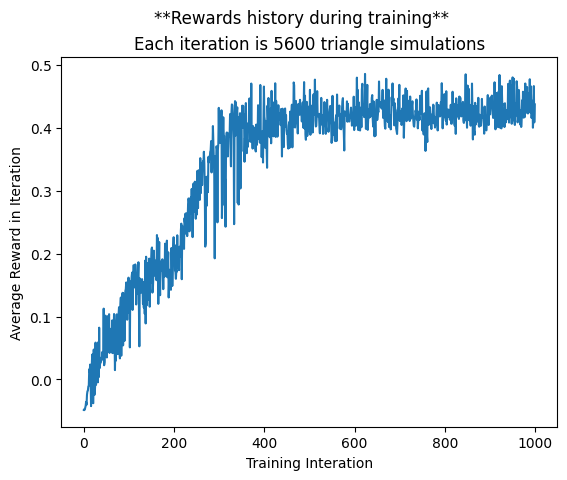

In [10]:
plt.plot(full_rewards_history.flatten())
plt.suptitle("**Rewards history during training**")
plt.title(f"Each iteration is {num_inits*batch_size} triangle simulations")
plt.xlabel("Training Interation")
plt.ylabel("Average Reward in Iteration")

In [11]:
def sample_to_string(sample):
            wordlist = ["ant",
                        "bat", "bear", "bee", "beaver",
                        "cat", "crab", "cow", "caribou",
                        "dog", "duck", "deer",
                        "elk",
                        "fox", "frog",
                        "goat", "goose",
                        "horse", "hawk",
                        "iguana",
                        "jaguar", "jackal",
                        "koala",
                        "llama", "lynx", "loon",
                        "mouse", "mole", "moose",
                        "newt", "narwhale",
                        "owl", "orca", "otter",
                        "pig", "panda", "parrot",
                        "quail",
                        "rabbit", "rat",
                        "seal", "shark", "swan","skunk",
                         "toad", "turtle", "tiger", "turkey",
                        "urchin",
                        "viper", "vulture",
                        "whale", "wolf", "walrus",
                        "yak","zebra",
                        "ant",
                        "bat", "bear", "bee", "beaver",
                        "cat", "crab", "cow"]
            #print(len(wordlist))
            wordlist = [entry.capitalize() for entry in wordlist]
            return wordlist[sample]

Starting Word: Orca
Step: 0, Action Word: Cat
Step: 0, Action Word: Cat
Step: 1, Action Word: Hawk
Step: 2, Action Word: Llama
Step: 3, Action Word: Elk
Step: 4, Action Word: Otter
Step: 5, Action Word: Cat
Step: 6, Action Word: Hawk
Step: 7, Action Word: Elk
Step: 8, Action Word: Otter


Step: 0, Action Word: Cat


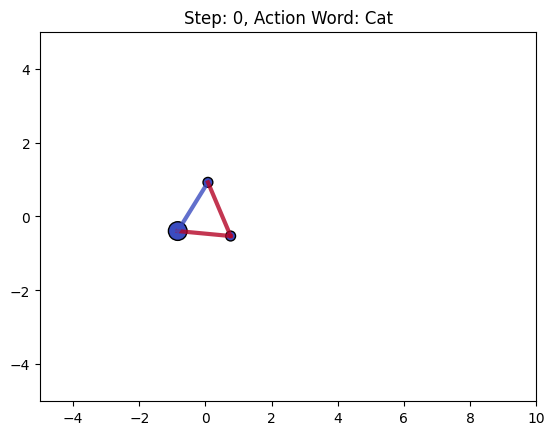

In [12]:
#params = params_checkpoints[5] #load some earleir parameters if you want!

num_frames_per_brain = 10 #number of frames to plot for each brain step. NOTE: MUST BE A DIVISOR OF num_physics_per_brain or else there are issues!

key = jax.random.PRNGKey(int(time.time())) #random time seed!

subkey, key = jax.random.split(key)
starting_word = jax.random.randint(subkey, shape=(), minval=0, maxval=num_inits).item()
print(f"Starting Word: {sample_to_string(starting_word)}")

my_pumps, my_muscles = decode_pumps_muscles(starting_word)

def create_plotting_episode(params,key,starting_word,num_frames_per_brain,my_temp=10):
  '''Creates a bunch of episodes and returns the action, input and reward histories that has all the info we need for plotting'''
  action_history = jnp.zeros((num_brain_steps),dtype=int) #record which word is being used
  my_points_history = jnp.zeros((num_frames_per_brain*num_brain_steps,3,2)) #record the inputs to the neural networks
  my_masses_history = jnp.zeros((num_frames_per_brain*num_brain_steps,3))


  key, subkey = jax.random.split(key)
  info_init = create_inits(subkey)

  my_points = info_init[0][starting_word]
  my_velocities = info_init[1][starting_word]
  my_masses = info_init[2][starting_word]
  my_pumps = info_init[3][starting_word]
  my_muscles = info_init[4][starting_word]


  for brain_step in range(num_brain_steps):



    inputs = get_input(my_points, my_velocities, my_masses, my_pumps, my_muscles)


    #Feed input into the brain and sample the muscles+pumps word
    log_probs = forward(params, inputs)
    key, subkey = jax.random.split(key)
    sample = jax.random.categorical(subkey, log_probs/my_temp) # sample_action(subkey, log_probs, temperature=my_temp)
    action_history = action_history.at[brain_step].set(sample)

    #Decode word to get pump and muscle values, and then do physics simulation
    my_pumps, my_muscles = decode_pumps_muscles(sample)

    for frame in range(num_frames_per_brain):
      my_points_history = my_points_history.at[frame + num_frames_per_brain*brain_step].set(my_points)

      my_masses_history = my_masses_history.at[frame + num_frames_per_brain*brain_step].set(my_masses)

      (my_points, my_velocities, my_masses, my_pumps, my_muscles) = jax.lax.fori_loop(0, num_physics_per_brain_step//num_frames_per_brain, triangle_update, (my_points, my_velocities, my_masses, my_pumps, my_muscles))


  return action_history, my_points_history, my_masses_history

action_history, my_points_history, my_masses_history = create_plotting_episode(params, subkey, starting_word, num_frames_per_brain, my_temp)


# Set up the figure and axis for the animation
fig, ax = plt.subplots()
sc = ax.scatter([], [], s=[], c=[], cmap="coolwarm", edgecolors="k", vmin=0, vmax=1)
lines = [ax.plot([], [], lw=3, alpha=0.8)[0] for _ in range(3)]  # One for each edge

ax.set_xlim(-5, 10)
ax.set_ylim(-5, 5)

def update_frame(i):
    global key, my_points, my_velocities, my_masses, my_pumps, my_muscles
    if i % num_frames_per_brain == 0:

      sample = action_history[i//num_frames_per_brain]
      my_title = f"Step: {i//num_frames_per_brain}, Action Word: {sample_to_string(sample)}"
      plt.title(my_title)
      print(my_title)
      my_pumps, my_muscles = decode_pumps_muscles(sample)
      #print(*[int(my_pumps[i]) for i in range(3)], *[int(my_muscles[i]) for i in range(3)])

    my_points = my_points_history[i]
    my_masses = my_masses_history[i]
    # Extract x and y coordinates of vertices
    x, y = my_points[:, 0], my_points[:, 1]

    # Update vertex sizes (proportional to mass)
    sizes = jnp.sqrt(my_masses)*50  # Scale appropriately for visibility

    # Update vertex colors (based on my_pumps)
    vertex_colors = my_pumps

    # Update edges
    for j, (p1, p2) in enumerate([(0, 1), (0,2), (1, 2)]):
        lines[j].set_data([x[p1], x[p2]], [y[p1], y[p2]])

        # Set edge color based on my_muscles
        color_value = 1.0*my_muscles[j]
        lines[j].set_color(plt.cm.coolwarm(color_value))  # Apply colormap

    # Update scatter plot for vertices
    sc.set_offsets(my_points)
    sc.set_sizes(sizes)
    sc.set_array(vertex_colors)  # Apply colormap to vertices

# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update_frame, frames=num_brain_steps*num_frames_per_brain, interval=100, blit=False)

# Display the animation in Google Colab using HTML
HTML(ani.to_html5_video())